# Problem 2, Parts A-B: Boosted Decision Tree

In this Jupyter notebook, we will train a boosted decision tree on the MiniBooNE dataset.

Use this notebook to write your code for problem 1 parts A-B by filling in the sections marked `# TODO` and running all cells.

In [16]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np

data = fetch_openml("miniboone", parser="auto", version=1)
X, y = data["data"].values, (data["target"].values == "True").astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# we will replace -999 values with nan
X_train_nan = X_train.copy()
X_test_nan = X_test.copy()
X_train_nan[X_train_nan == -999] = np.nan
X_test_nan[X_test_nan == -999] = np.nan

In [17]:
import xgboost as xgb
from xgboost import XGBClassifier
# help(XGBClassifier)

## Problem 1A

Using the MiniBooNE dataset and XGBoost, train a boosted decision tree on the
training dataet. Use the Scikit-learn API xgboost.XGBClassifier. For an initial choice of hyperparam-
eters use 100 trees (n_estimators), maximum tree depth (max_depth) of 10, learning rate (learning_-
rate) of 0.1, colsample_bytree of 0.8, and subsample of 0.8.

In [23]:
bdt = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, colsample_bytree=0.8, subsample=0.8, missing=np.nan)

bdt.fit(X_train_nan, y_train)

# retrieve predictions and take index [:, 1] corresponding to signal
preds_bdt = bdt.predict_proba(X_test_nan)[:, 1]

Plot the receiver operating characteristic (ROC) curve using the testing dataset. What area under the curve
(AUC) and accuracy do you achieve “out of the box”?

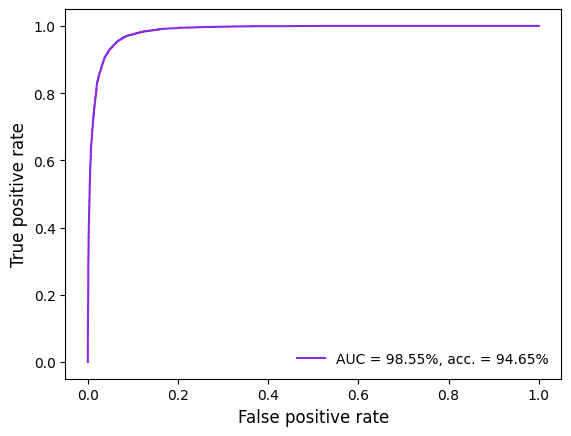

Out of the box AUC score:  0.985517099482699


In [24]:
from roc_helper import plot_roc
from sklearn.metrics import roc_auc_score

plot_roc(y_test, preds_bdt)

print("Out of the box AUC score: ", roc_auc_score(y_test, preds_bdt))

## Problem B

Plot the F -score for all the 10 “most important” features using xgboost.plot_-
importance. Which feature is the most important?

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

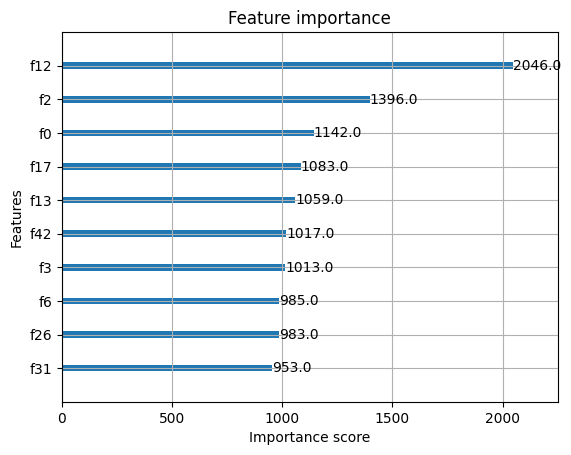

In [25]:
xgb.plot_importance(bdt, max_num_features=10)

Plot this feature using the testing dataset in a 1D histogram separately for signal and background. For the
histogram binning, use 100 bins from the minimum value of this feature to the maximum value of this
feature in the testing dataset. What do you notice about this feature?

In [26]:
print("feature importances:", bdt.feature_importances_)
mostImportantFeatureIndex = bdt.feature_importances_.argmax()
print("index of most important feature:", mostImportantFeatureIndex)

feature importances: [0.14830358 0.03590808 0.06199352 0.01924888 0.00990884 0.01674963
 0.01012039 0.00547907 0.01095806 0.01175756 0.00906722 0.0175198
 0.02652111 0.01260436 0.00590355 0.02606802 0.21215528 0.0125186
 0.00715029 0.0085146  0.01552007 0.00569812 0.01689242 0.01103275
 0.00716781 0.01013281 0.03013023 0.01248626 0.00840262 0.00843518
 0.00875764 0.05760893 0.00693328 0.00857107 0.00599446 0.00671542
 0.0097631  0.00842314 0.00878978 0.007201   0.00729554 0.00721466
 0.00903414 0.00612234 0.01019761 0.01051529 0.00712592 0.00789544
 0.00536827 0.00612429]
index of most important feature: 16


feature min, max: 0.0 16.0604
unique values count: 25086


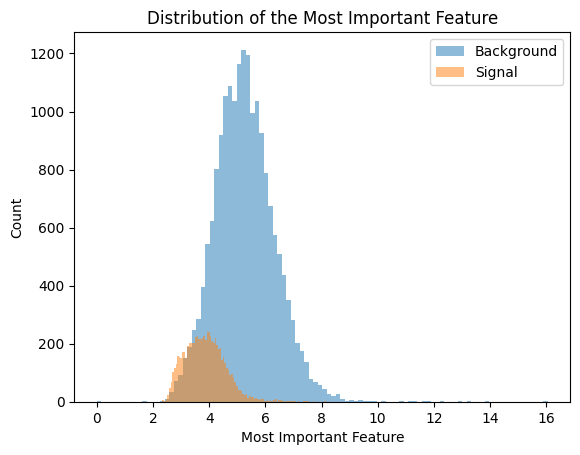

In [27]:
import numpy as np
import matplotlib.pyplot as plt

feat_vals = X_test_nan[:, 0]

xmin = np.nanmin(feat_vals)
xmax = np.nanmax(feat_vals)

signal_vals = X_test_nan[y_test == 1, 0]
background_values = X_test_nan[y_test == 0, 0]

print("feature min, max:", xmin, xmax)
print("unique values count:", len(np.unique(feat_vals)))

# Create 100 bins between min and max (101 edges)
bins = 100

plt.hist(background_values, bins=bins, alpha=0.5, label="Background")
plt.hist(signal_vals, bins=bins, alpha=0.5, label="Signal")
plt.xlabel("Most Important Feature")
plt.ylabel("Count")
plt.title("Distribution of the Most Important Feature")
plt.legend()
plt.show()

# Problem 2, Parts C-E: Neural Network

In this Jupyter notebook, we will train a neural network on the MiniBooNE dataset.

Use this notebook to write your code for problem 1 parts C-E by filling in the sections marked `# TODO` and running all cells.

## Problem C
Using the MiniBooNE dataset and the Keras Model API, train a neural network
with 3 hidden layers each with 128 units and tanh activations. The final layer should have sigmoid activa-
tion. Use the binary crossentropy loss function, the SGD optimizer with a learning rate of 0.01 (which is the
default), and a batch size of 128. Train the model for 50 epochs.

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

inputs = Input(shape=(X_train_nan.shape[1],))
x = Dense(128, activation='tanh')(inputs)
x = Dense(128, activation='tanh')(x)
x = Dense(128, activation='tanh')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_nan, y_train, epochs=50, batch_size=128, validation_data=(X_test_nan, y_test))

# retrieve predictions
preds_nn = model.predict(X_test_nan)

Epoch 1/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7199 - loss: nan - val_accuracy: 0.7173 - val_loss: nan
Epoch 2/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7199 - loss: nan - val_accuracy: 0.7173 - val_loss: nan
Epoch 3/50
505/813 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7220 - loss: nan

KeyboardInterrupt: 

Plot the receiver operating characteristic (ROC) curve using the testing dataset. What AUC and accuracy
do you achieve “out of the box”?

Out of the box AUC score:  0.9181823395377046


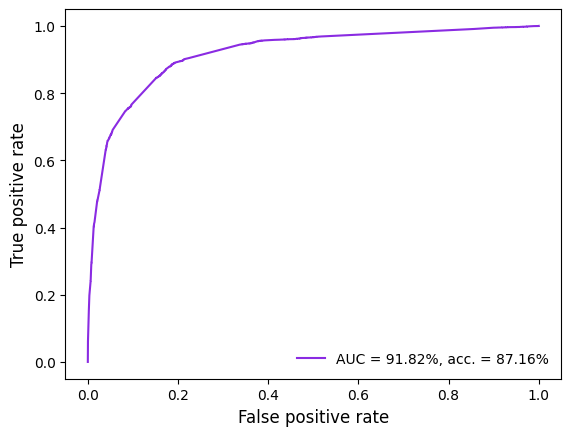

In [ ]:
from roc_helper import plot_roc
print("Out of the box AUC score: ", roc_auc_score(y_test, preds_nn))
outoftheboxplot = plot_roc(y_test, preds_nn)
plt.close()

## Problem D
Swap out the tanh activations for ReLU activations, while keeping everything else
the same. Does the network train effectively? Why or why not?

In [14]:
inputs = Input(shape=X_train_nan.shape[1:])
x = Dense(128, activation='relu')(inputs)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_nan, y_train, epochs=50, batch_size=128, validation_data=(X_test_nan, y_test))

# retrieve predictions
preds_nn = model.predict(X_test_nan)

Epoch 1/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7194 - loss: 0.6120 - val_accuracy: 0.7173 - val_loss: 0.5956
Epoch 2/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7199 - loss: 0.5932 - val_accuracy: 0.7173 - val_loss: 0.5956
Epoch 3/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7199 - loss: 0.5932 - val_accuracy: 0.7173 - val_loss: 0.5955
Epoch 4/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7199 - loss: 0.5931 - val_accuracy: 0.7173 - val_loss: 0.5957
Epoch 5/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7199 - loss: 0.5932 - val_accuracy: 0.7173 - val_loss: 0.5956
Epoch 6/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7199 - loss: 0.5932 - val_accuracy: 0.7173 - val_loss: 0.5955
Epoch 7/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7199 - loss: 0.5932 - val_accuracy: 0.7173 - val_loss: 0.5956
Epoch 8/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7199 - loss: 0.5932 - val_accuracy: 0.

Out of the box AUC score:  0.5


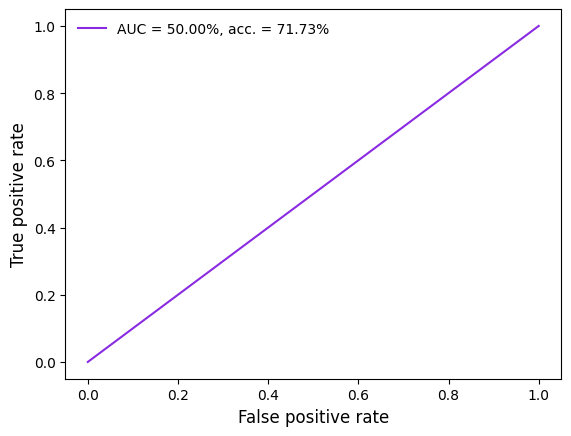

In [15]:
print("Out of the box AUC score: ", roc_auc_score(y_test, preds_nn))
plot_roc(y_test, preds_nn)
plt.close()

For the features all values are already positive so ReLU acts like a linear model. In problem E we will standardize the input features so it shouldnt be a problem anymore. 

## Problem E
Now, we will make two minor changes to the network with ReLU activations:
preprocessing and the optimizer.
For the feature preprocessing use sklearn.preprocessing.StandardScaler to standardize the input
features. Note you should ﬁt the standard scaler to the training data only and apply it to both the training
and testing data. For the optimizer, use Adam with a learning rate of 0.001 (which is the default) instead of
SGD. Train the model for 50 epochs

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

inputs = Input(shape=X_train_scaled.shape[1:])
outputs = Dense(128, activation='relu')(inputs)
outputs = Dense(128, activation='relu')(outputs)
outputs = Dense(128, activation='relu')(outputs)
outputs = Dense(1, activation='sigmoid')(outputs)
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=128, validation_data=(X_test_scaled, y_test))

preds_nn = model.predict(X_test_scaled)

Epoch 1/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8918 - loss: 0.2581 - val_accuracy: 0.8962 - val_loss: 0.2455
Epoch 2/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9097 - loss: 0.2141 - val_accuracy: 0.9111 - val_loss: 0.2112
Epoch 3/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9169 - loss: 0.1986 - val_accuracy: 0.9199 - val_loss: 0.1957
Epoch 4/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9216 - loss: 0.1892 - val_accuracy: 0.9149 - val_loss: 0.2017
Epoch 5/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9248 - loss: 0.1824 - val_accuracy: 0.9212 - val_loss: 0.1917
Epoch 6/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9269 - loss: 0.1791 - val_accuracy: 0.9253 - val_loss: 0.1814
Epoch 7/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9282 - loss: 0.1743 - val_accuracy: 0.9256 - val_loss: 0.1789
Epoch 8/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9298 - loss: 0.1725 - val_accuracy: 0.

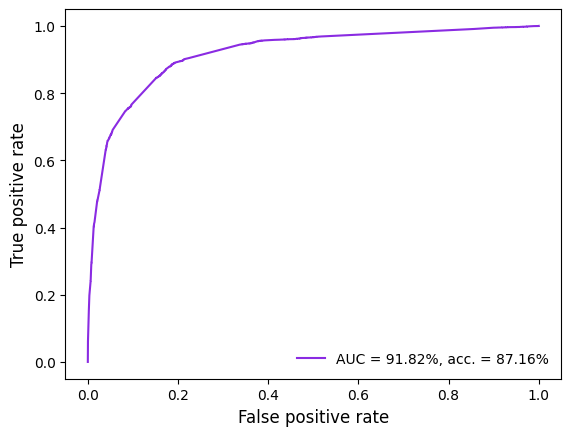

In [12]:
outoftheboxplot

Scaled AUC score:  0.9853748961867481


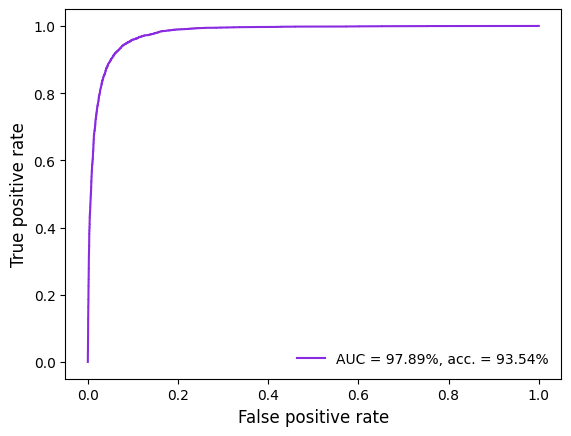

In [13]:
print("Scaled AUC score: ", roc_auc_score(y_test, preds_bdt))
plot_roc(y_test, preds_nn)
plt.close()

It performs around 6-9% better than the out of the box NN version. The scaled NN AUC closesly resembles the BDT version, only slightly (0.5%) worse.